# Table of Contents

[Question 1](#one) [Question 2](#two)

In [1]:
import pandas as pd
import numpy as np


#visualizations libraries
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()

plt.style.use('bmh')
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

#machine learning libraries
import xgboost as xgb
import catboost as cb 
from sklearn.metrics import mean_squared_error

from matplotlib import patheffects
import statsmodels.api as sm

import os

#project modules
import src.wrangle as wr
import src.summaries as su
import src.explore as ex

%config InlineBackend.figure_format = 'retina'
pd.set_option('display.float_format', lambda x: '%.5f' % x)
from importlib import reload

import warnings
warnings.filterwarnings('ignore')

# one

-[return to TOC](#Table-of-Contents)

- We know that the covid-19 global pandemic altered business in the United States among countries of the world. Certainly Cisco Systems' sales in the state of Texas would be effected somehow. I set out to see if there would be large anamolous activities around the year 2020. First, I found that there is an enormous jump in quantities of orders from customers. This jump occured on Janurary 2, 2020. Texas Health and Human Services Commission purchased 3,767,123 units of something and 865,822 unites of something else. What were the things purchased? We cannot say from this data but considering the first order had a price of  0.00186 𝑝𝑒𝑟 𝑢𝑛𝑖𝑡 𝑎𝑛𝑑 0.00085 per unit, we speculate that it might be licenses for cisco connect, Cisco System's VPN service.

- We found that a large purchase order like this is made for Texas Health and Human Services periodically, but the purchase is limited to around 1 million somethings. This purchase probably had to do with foresight regarding what could come given the brewing pandemic which was being reported in China.

- You may follow the following graphs to see the findings

In [34]:
def clean_df():
    df = wr.get_clean_data(start2018=True)
    df = df.drop(columns = ['shipped_date', 'order_date_copy'])
    df['purchase_amount'] = df['purchase_amount'].astype('int64')
    df['customer_zip'] = df['customer_zip'].astype('int8')
    df['order_quantity'] = df['order_quantity'].astype('int64')
    df['unit_price'] = df['unit_price'].astype('float64')
    
    return df

In [35]:
df = clean_df()

### Notice the large order quantity outlier

<AxesSubplot:xlabel='Order Quantity'>

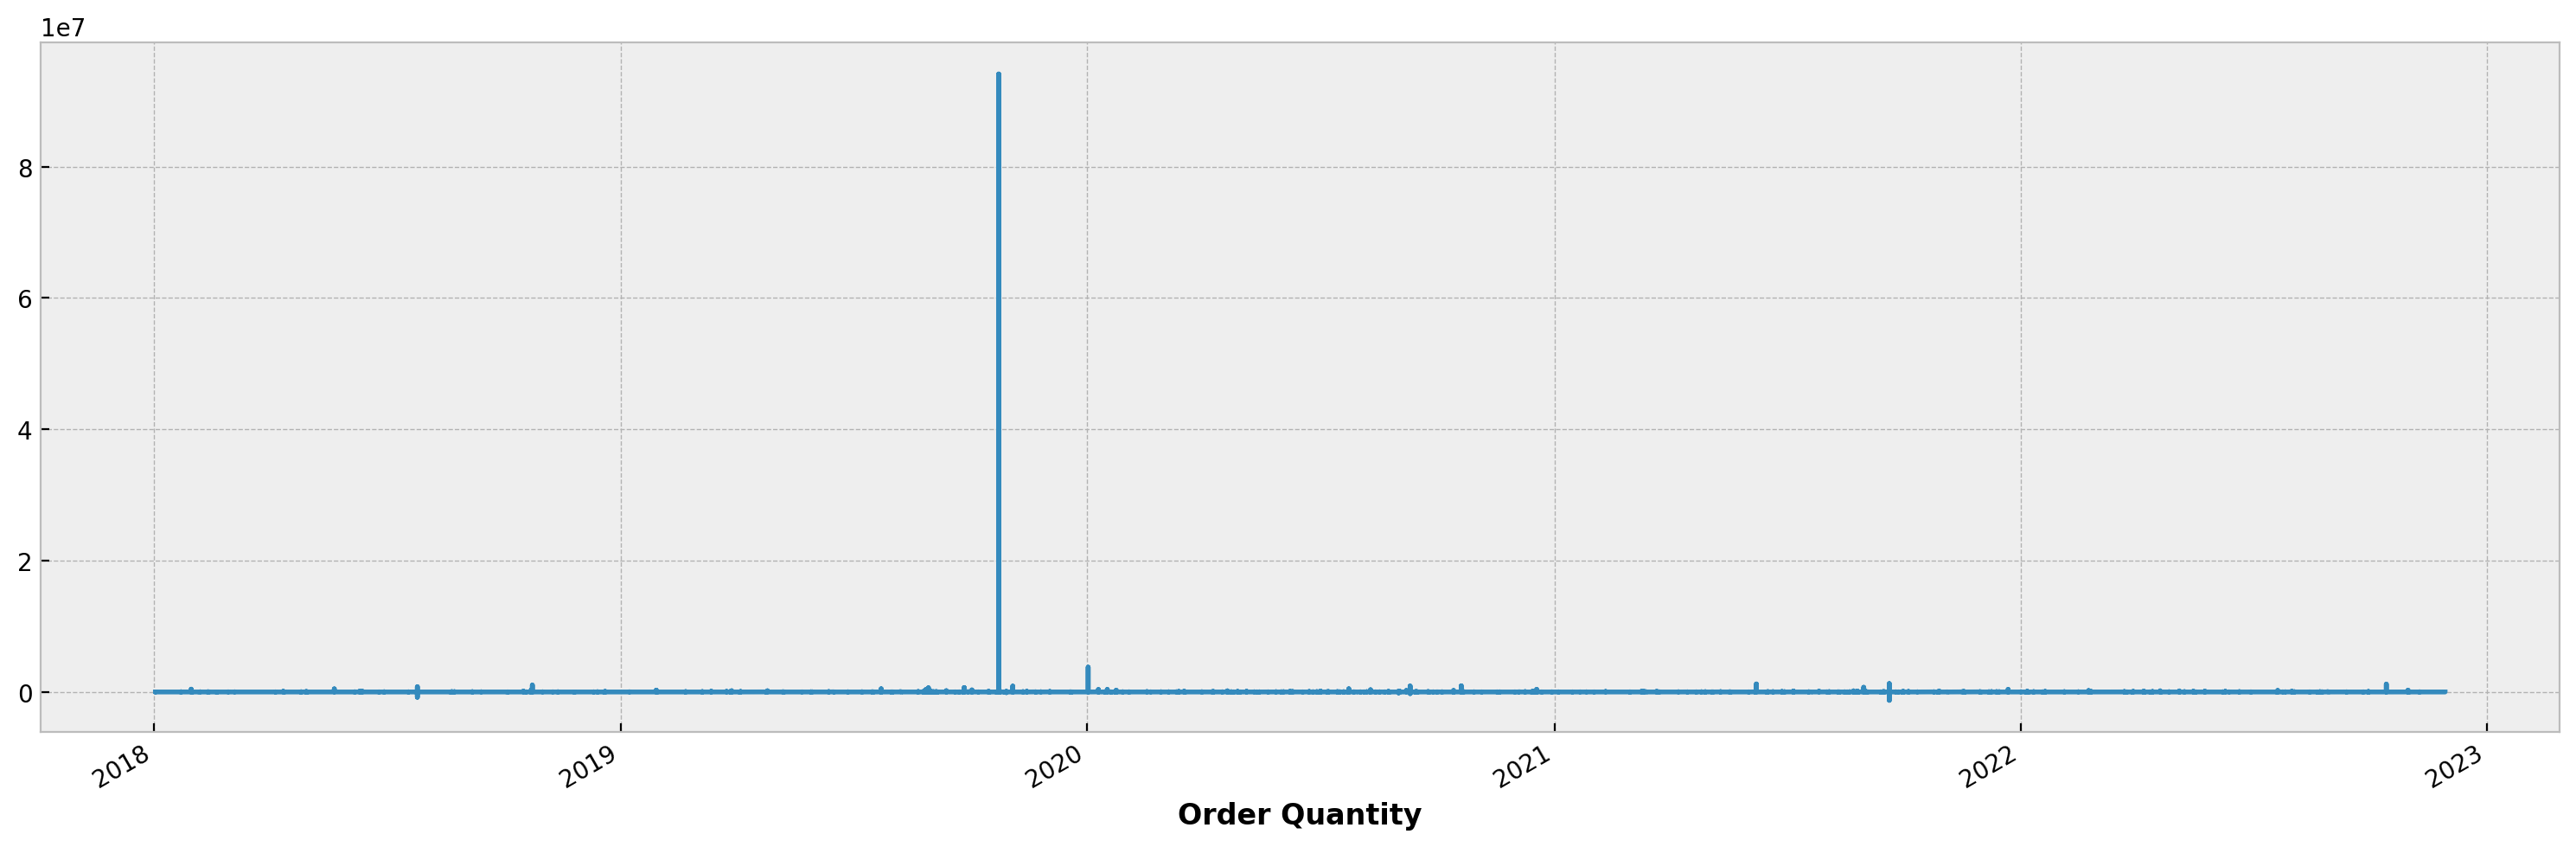

In [36]:
fix, ax = plt.subplots(figsize = (15,5))
df['order_quantity'].plot(ax=ax, xlabel='Order Quantity')

In [56]:
import statsmodels.api as sm

### Isolating the pandemic year

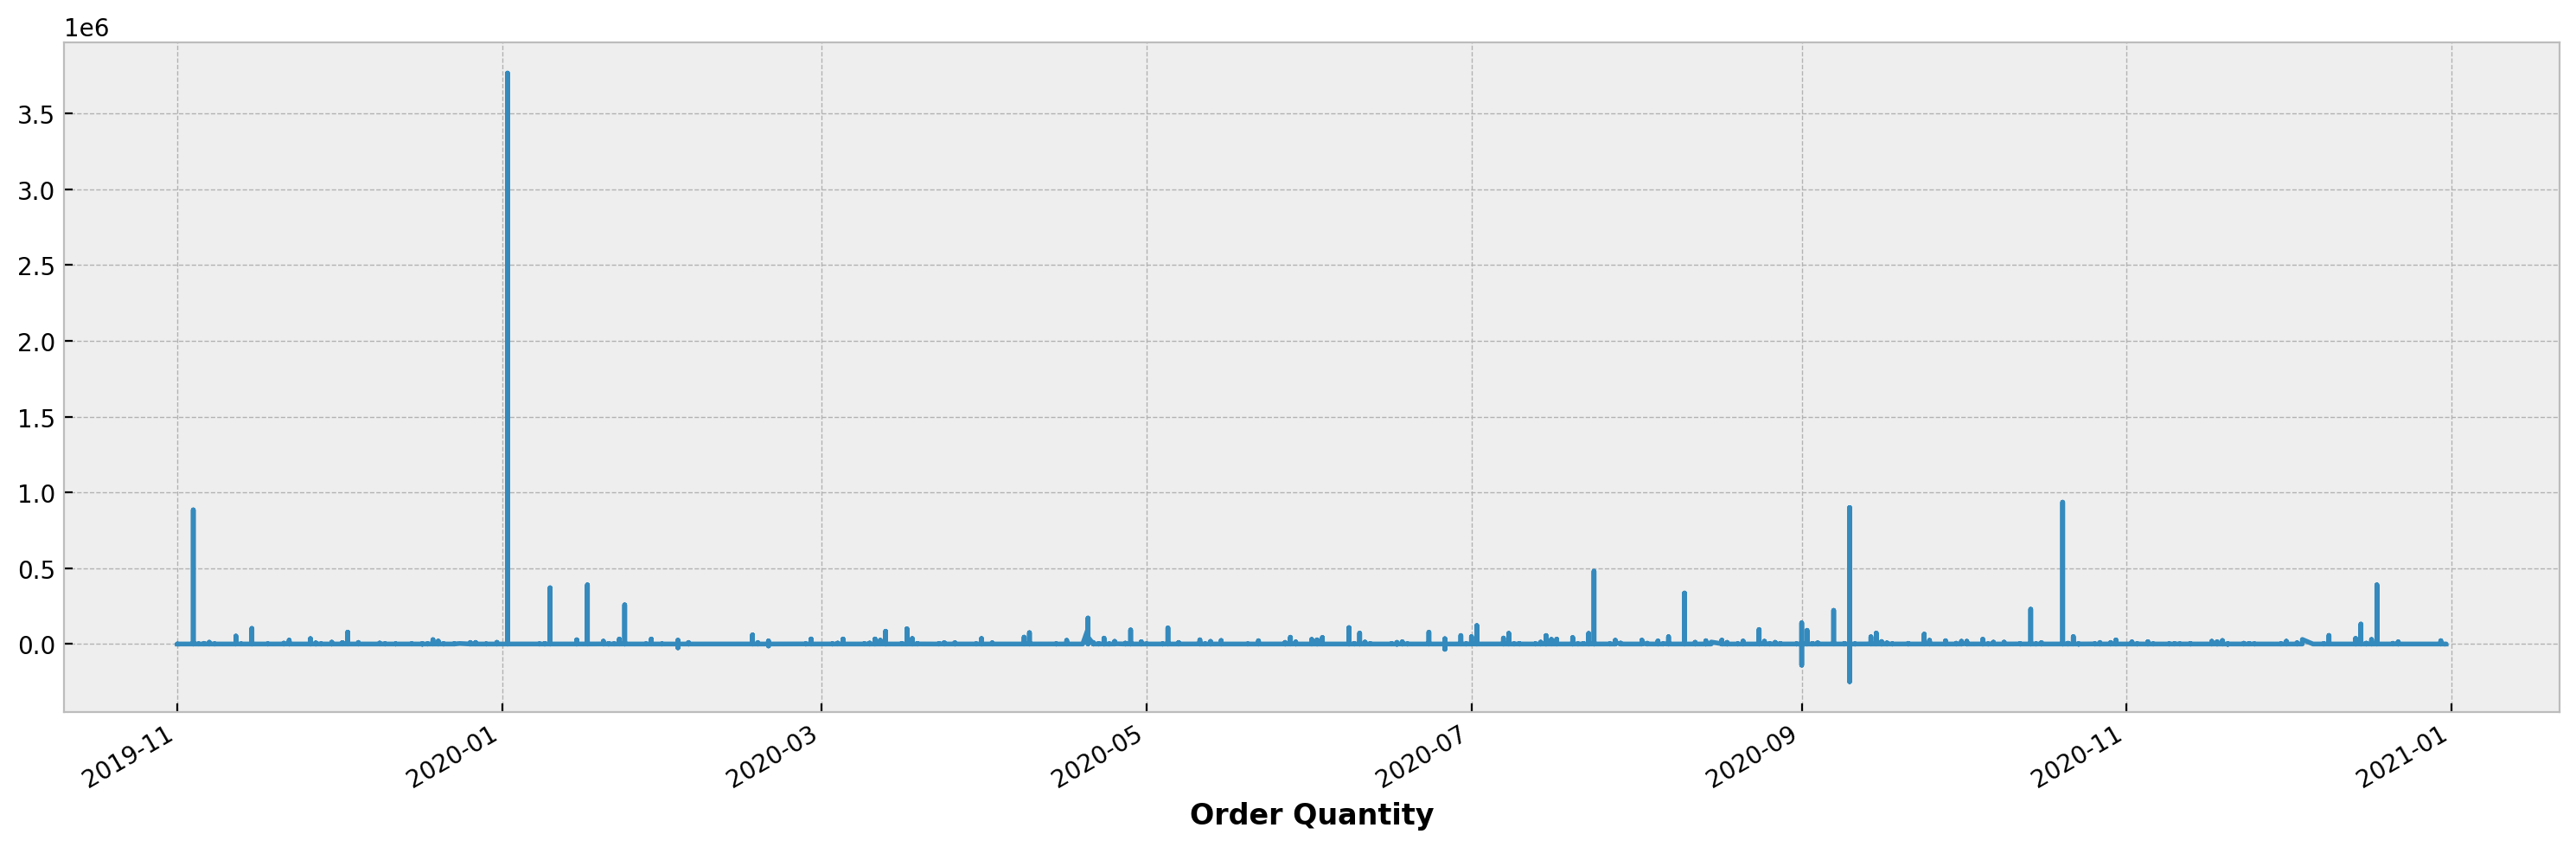

In [42]:
pandemic_df = df.loc[df.index >= '11-01-2019']
pandemic_df = pandemic_df.loc[pandemic_df.index < '01-01-2021']


fix, ax = plt.subplots(figsize = (15,5))
#ax = pandemic_df.plot(x_compat=True)-
pandemic_df['order_quantity'].plot(ax=ax, xlabel='Order Quantity')
plt.show()

### Taking a peek at who the big buyers were on that anomolous day

<BarContainer object of 6 artists>

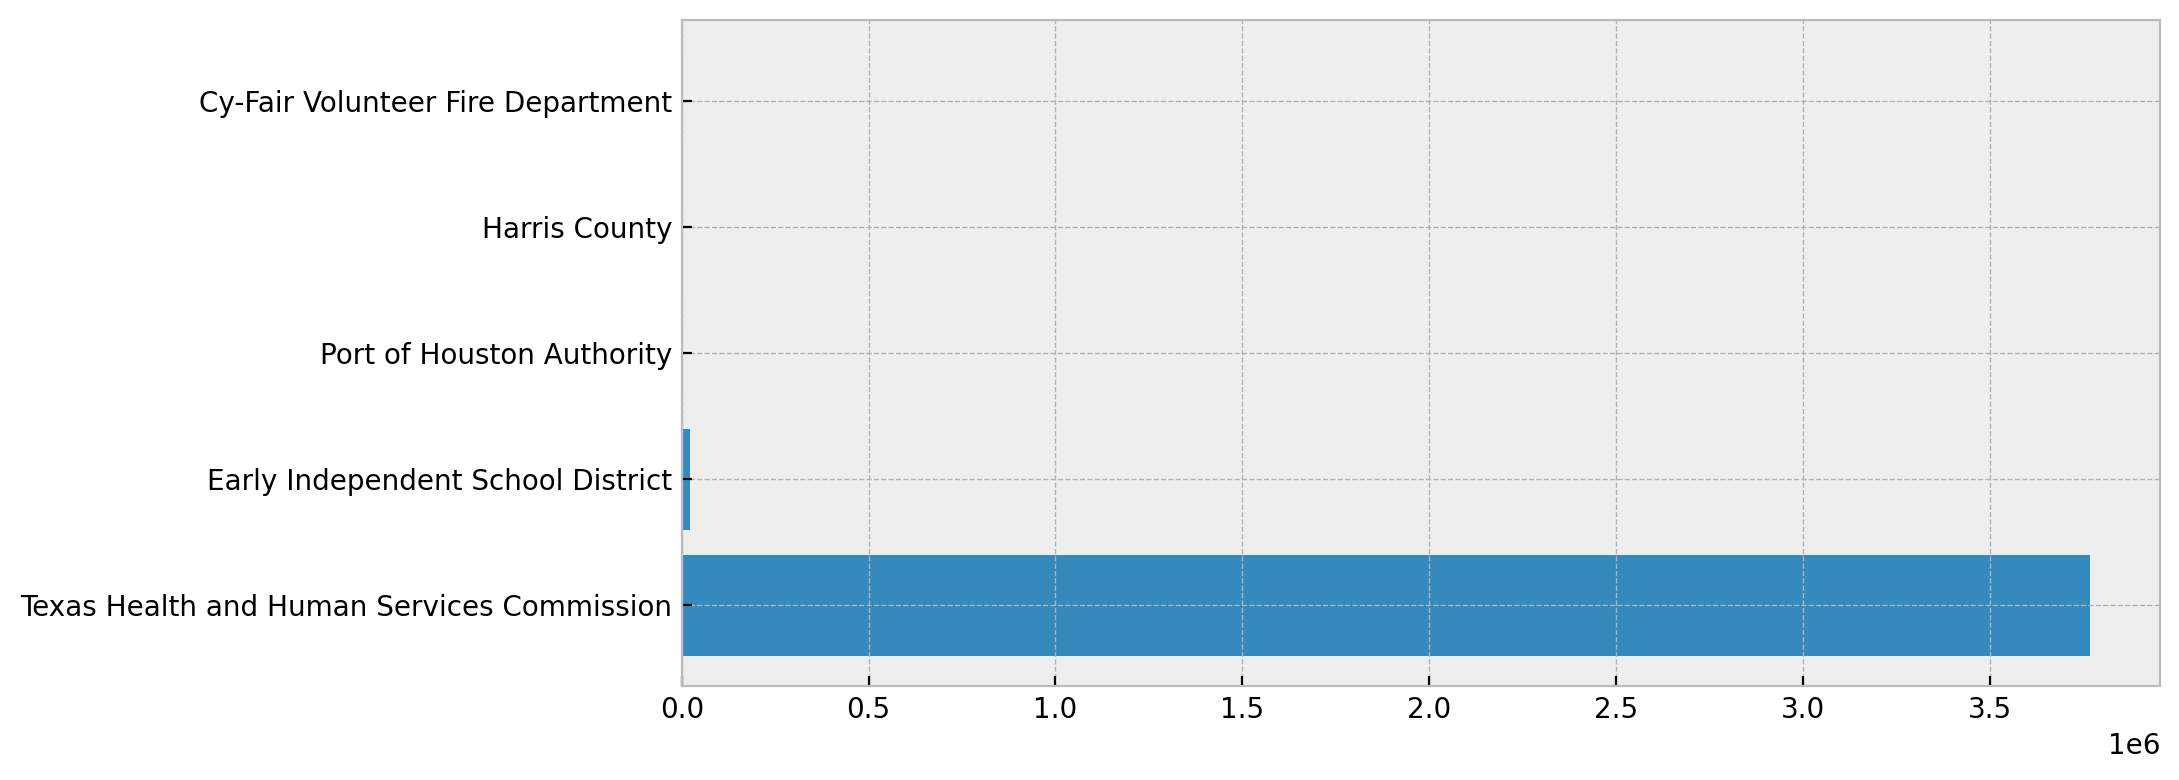

In [44]:
jan2 = pandemic_df.loc[pandemic_df.index == '01-02-2020']
jan2purchases = jan2.sort_values(by=['order_quantity'], ascending = False).head(6)
fig, ax = plt.subplots()
ax.barh(jan2purchases.customer_name, jan2purchases.order_quantity)

## We can see that Texas Health and Human Services Commission purchased close to 4 million somethings from Cisco Systems one time, outside of any predictable pattern

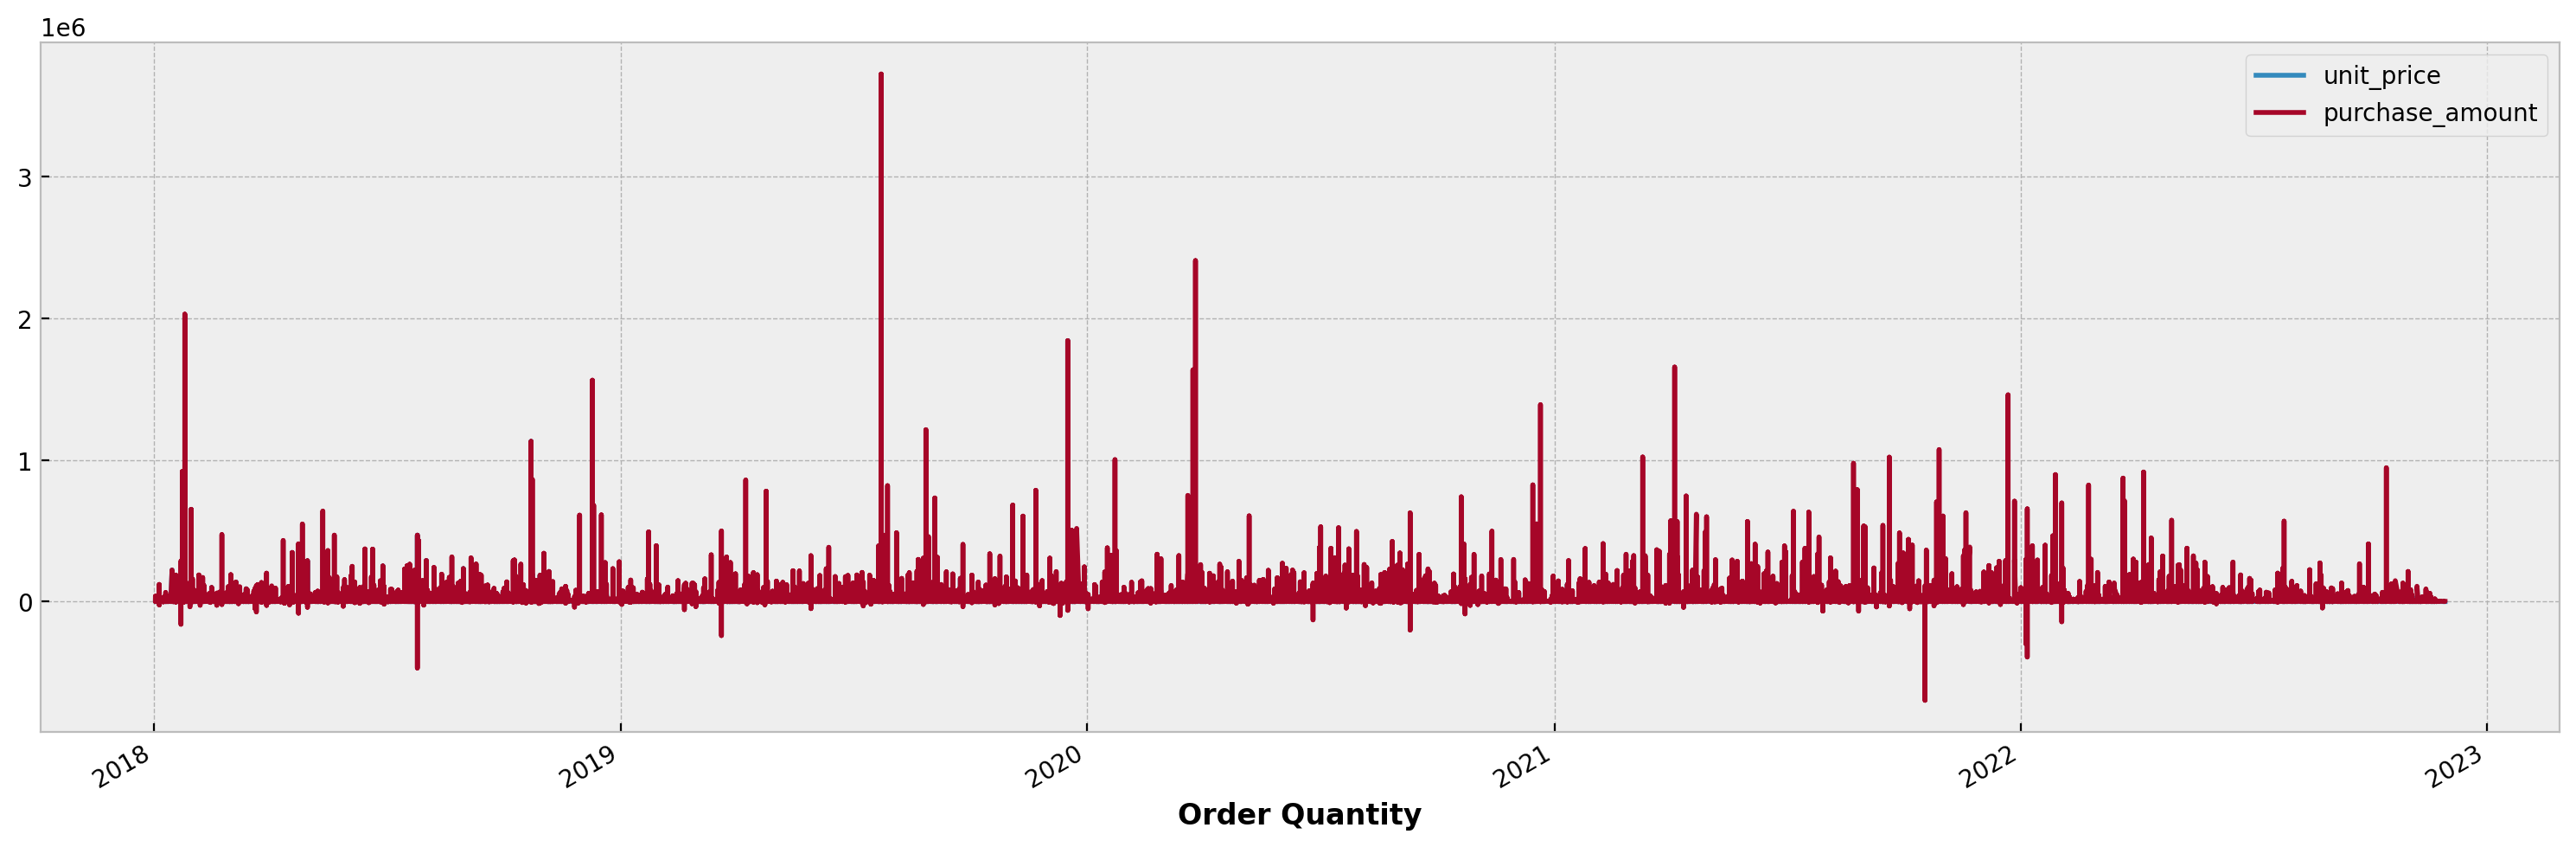

In [40]:
pandemic_df = df.loc[df.index >= '11-01-2019']
pandemic_df = pandemic_df.loc[pandemic_df.index < '01-01-2021']
#pandemic_df = df.drop(columns = ['order_quantity', 'customer_zip', 'year', 'quarter', 'month', 'week', 'day_of_week', 'day_of_year'])

fix, ax = plt.subplots(figsize = (15,5))
#ax = pandemic_df.plot(x_compat=True)-
pandemic_df.plot(ax=ax, xlabel='Order Quantity')
plt.show()

<AxesSubplot:xlabel='Unit Price'>

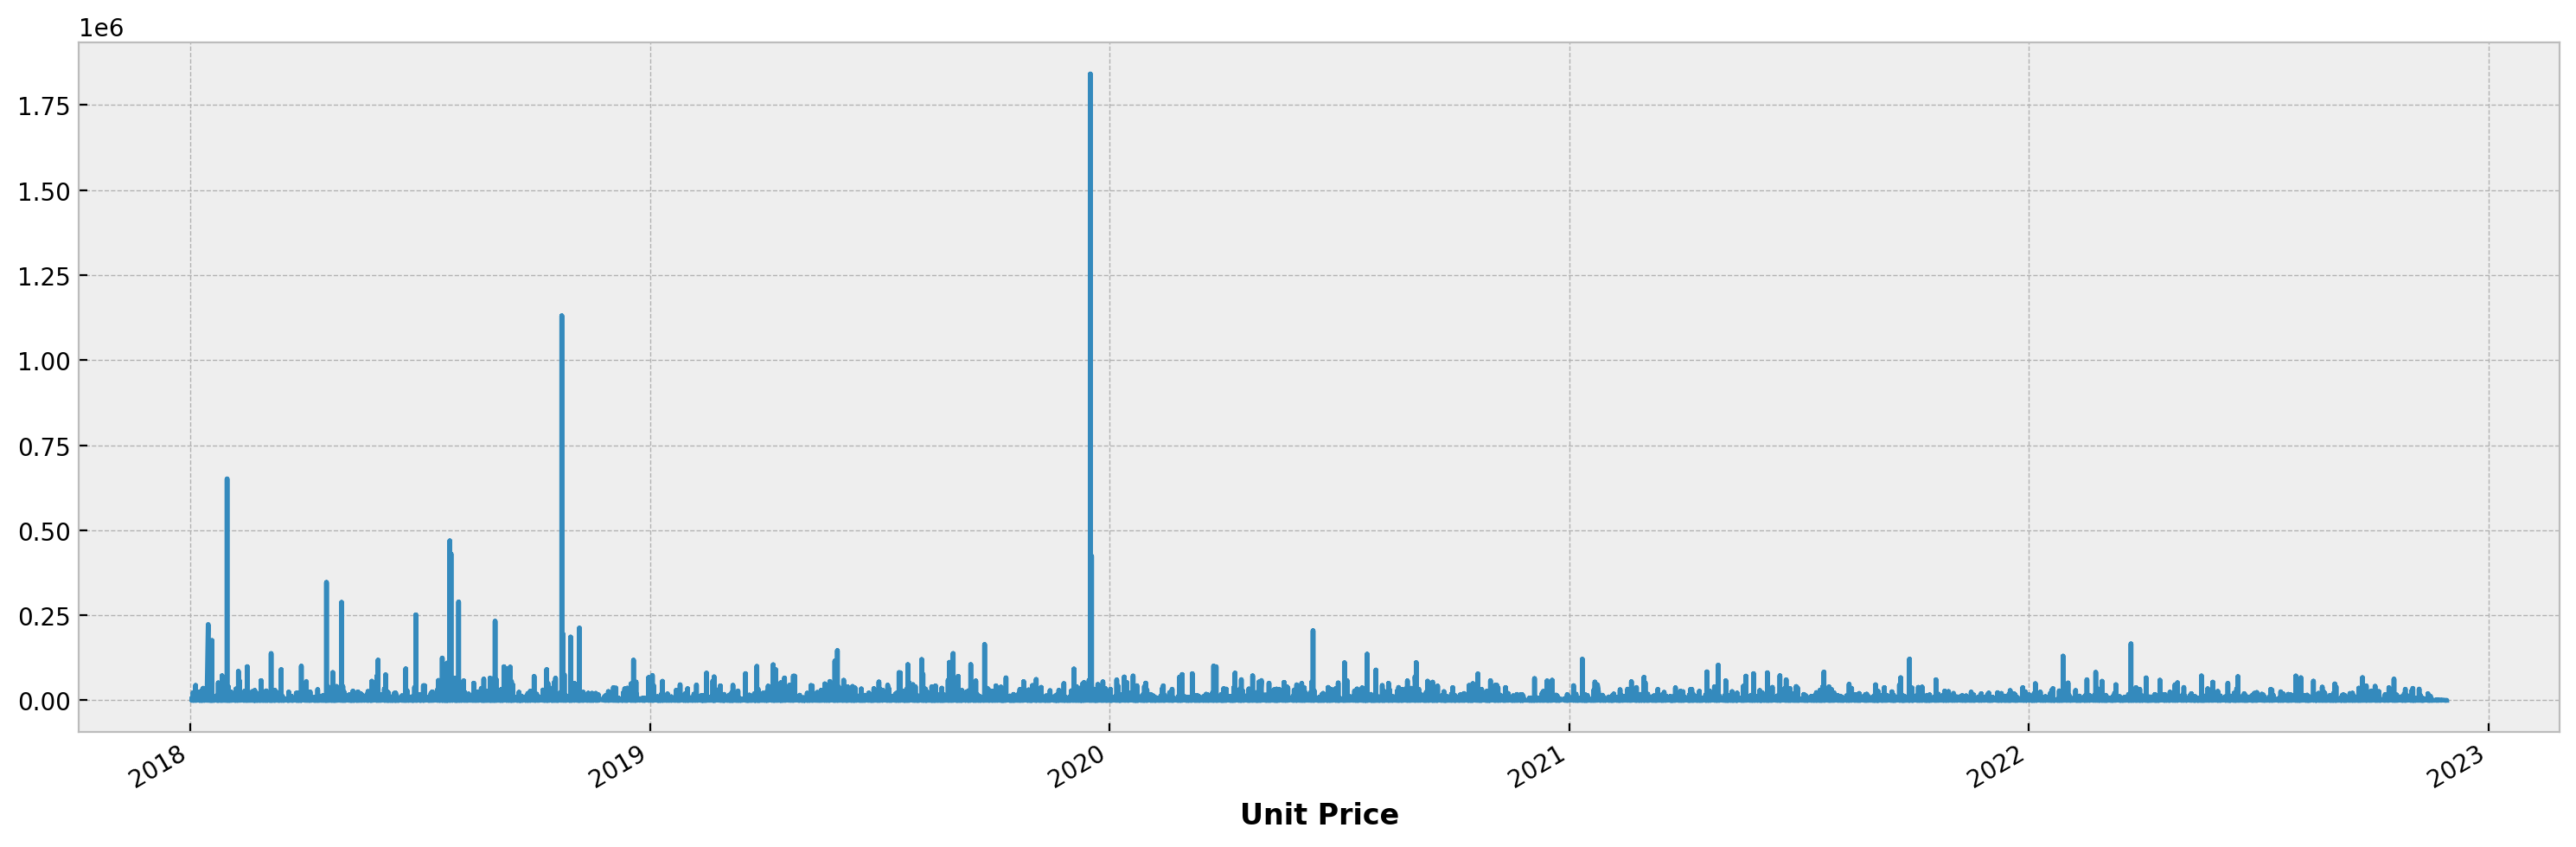

In [11]:
fix, ax = plt.subplots(figsize = (15,5))
df['unit_price'].plot(ax=ax, xlabel='Unit Price')

# two

-[return to TOC](#Table-of-Contents)

- It seems that Cisco Systems' revenue model is one which is based around two types of products. One product is purchased annually, for a small price, and in potentially large quantities.The second type of product is purchased less regularly, in smaller quantities, and for larger prices
- If this is the case, then predicting sales revenues from Texas' agency purchases will require two models. One which predicts the first kind of product, the other which predicts the second kind of product. I will attempt to demonstrate these two kinds of product patterns

In [49]:
df = wr.get_clean_data(start2018=True)
train, test = wr.split_data(df, explore=True)
validate = test.loc[:'2022-06'].copy() 
test = test.loc['2022-07':]

### Note that the full dataset appears to have a lot of noise before it is modified

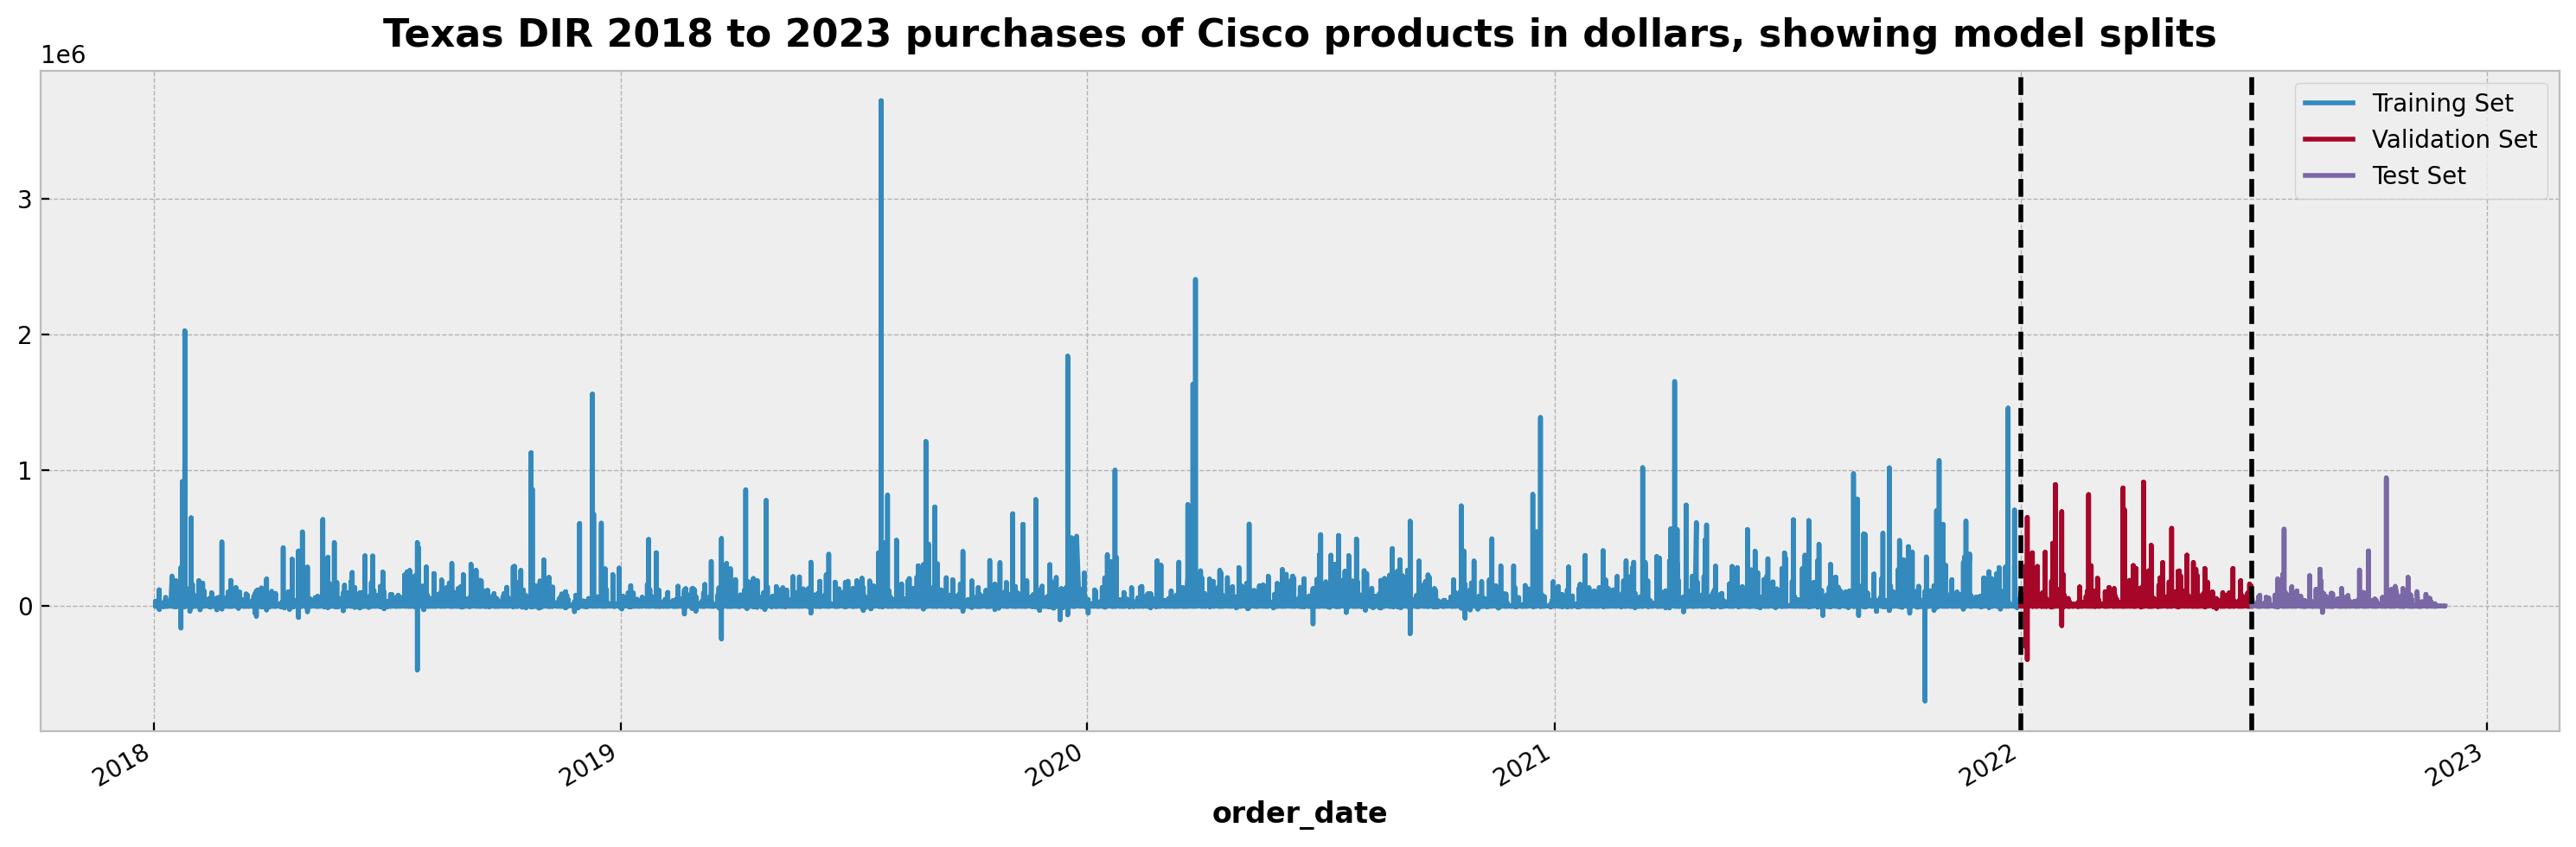

In [60]:
fix, ax = plt.subplots(figsize = (15,5))
train['purchase_amount'].plot(ax = ax, label='Training Set', title='Texas DIR 2018 to 2023 purchases of Cisco products in dollars, showing model splits')
validate['purchase_amount'].plot(ax = ax, label='Validation Set')
test['purchase_amount'].plot(ax = ax, label='Test Set')
ax.axvline('01-01-22', color='black', ls='--')
ax.axvline('07-01-22', color='black', ls='--')
ax.legend(['Training Set', 'Validation Set', 'Test Set'])
plt.show()

### Splitting between purchases of goods which are over \\$5 per unit and goods which are less than \\$5 per unit

In [52]:
df = clean_df()
n = 5
df_large_price = df[df['unit_price'] > n]
df_small_price = df[df['unit_price'] <= n]

lp_train, lp_test = wr.split_data(df_large_price, explore=True)
lp_validate = lp_test.loc[:'2022-06'].copy() 
lp_test = lp_test.loc['2022-07':]

sp_train, sp_test = wr.split_data(df_small_price, explore=True)
sp_validate = sp_test.loc[:'2022-06'].copy() 
sp_test = sp_test.loc['2022-07':]

### Viewing data over our time period for purchases over \\$5

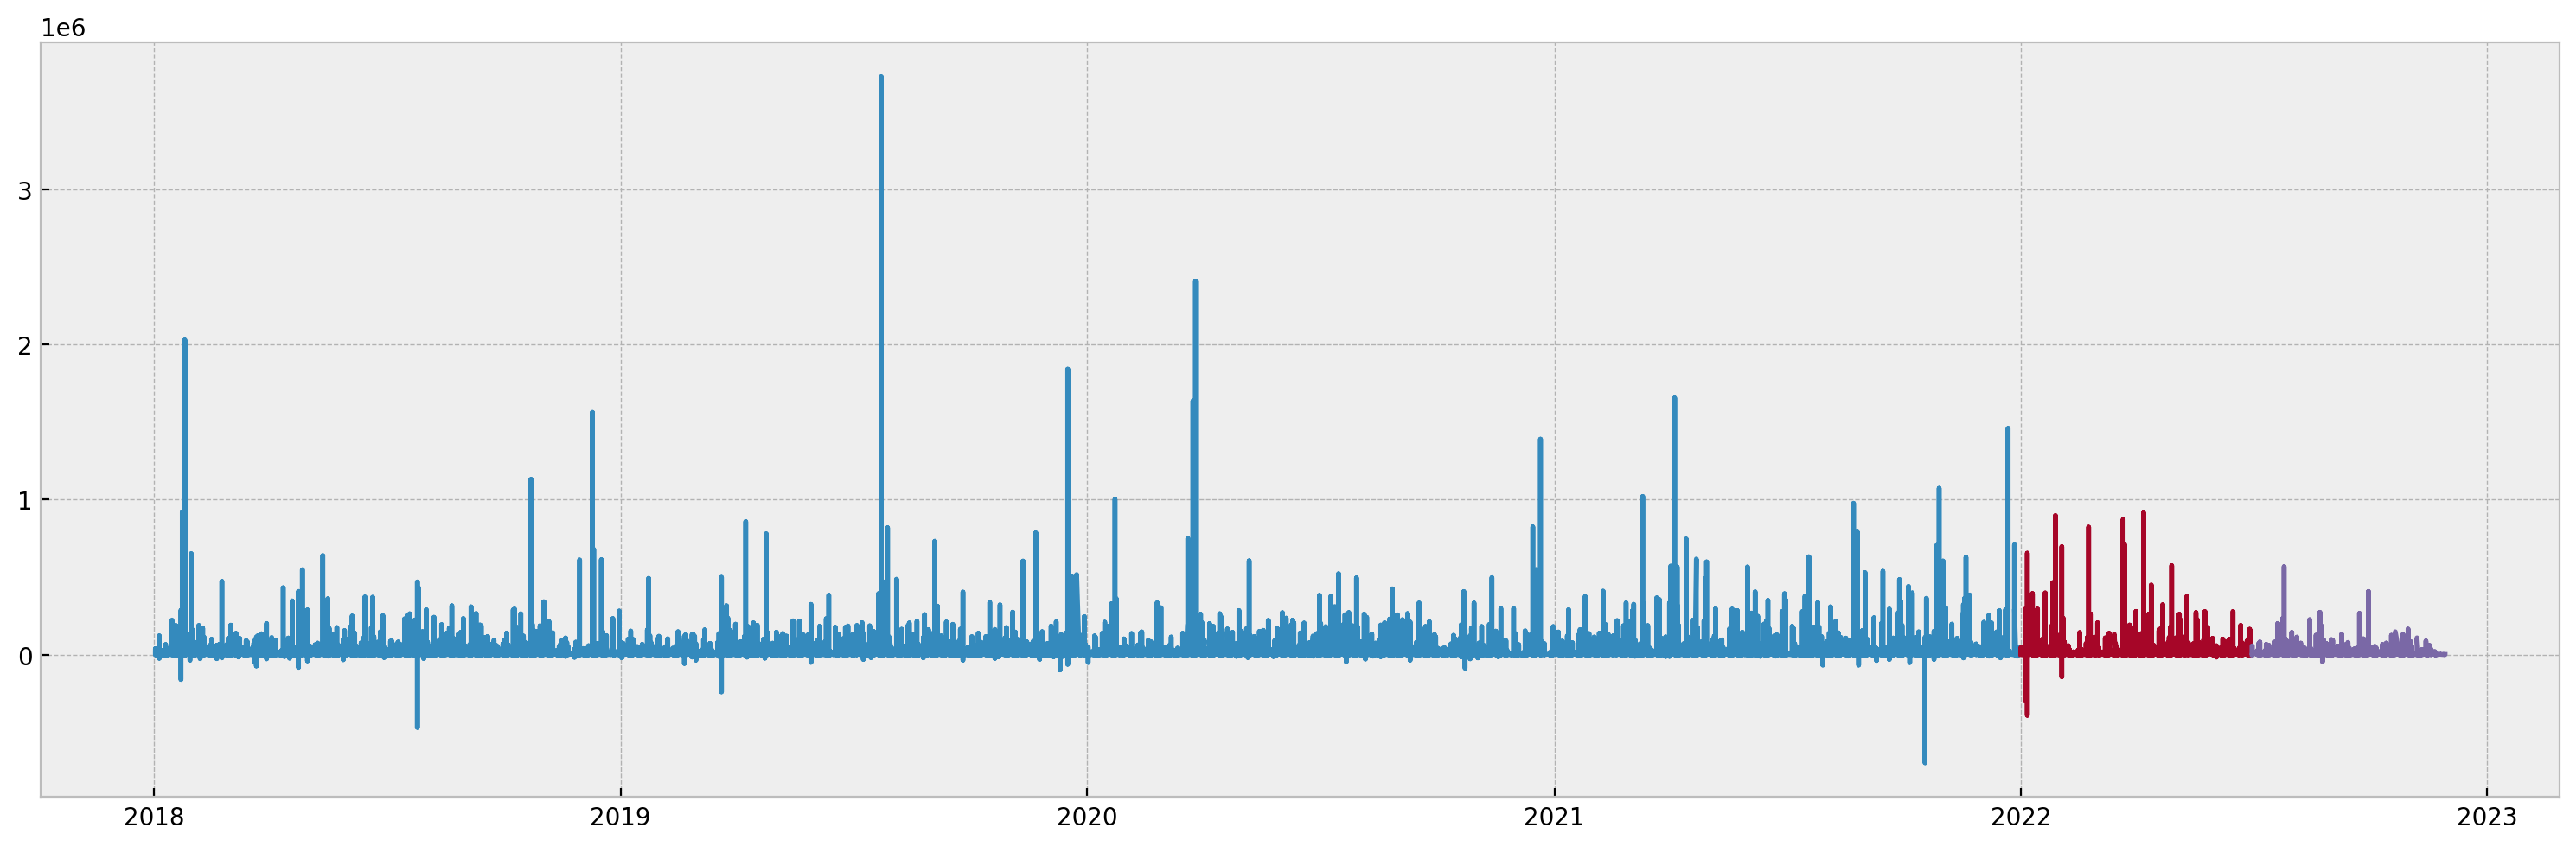

In [53]:
fix, ax = plt.subplots(figsize = (15,5))
plt.plot(lp_train.index, lp_train['purchase_amount'])
plt.plot(lp_validate.index, lp_validate['purchase_amount'])
plt.plot(lp_test.index, lp_test['purchase_amount'])

### Viewing data over our time period for purchases under \\$5

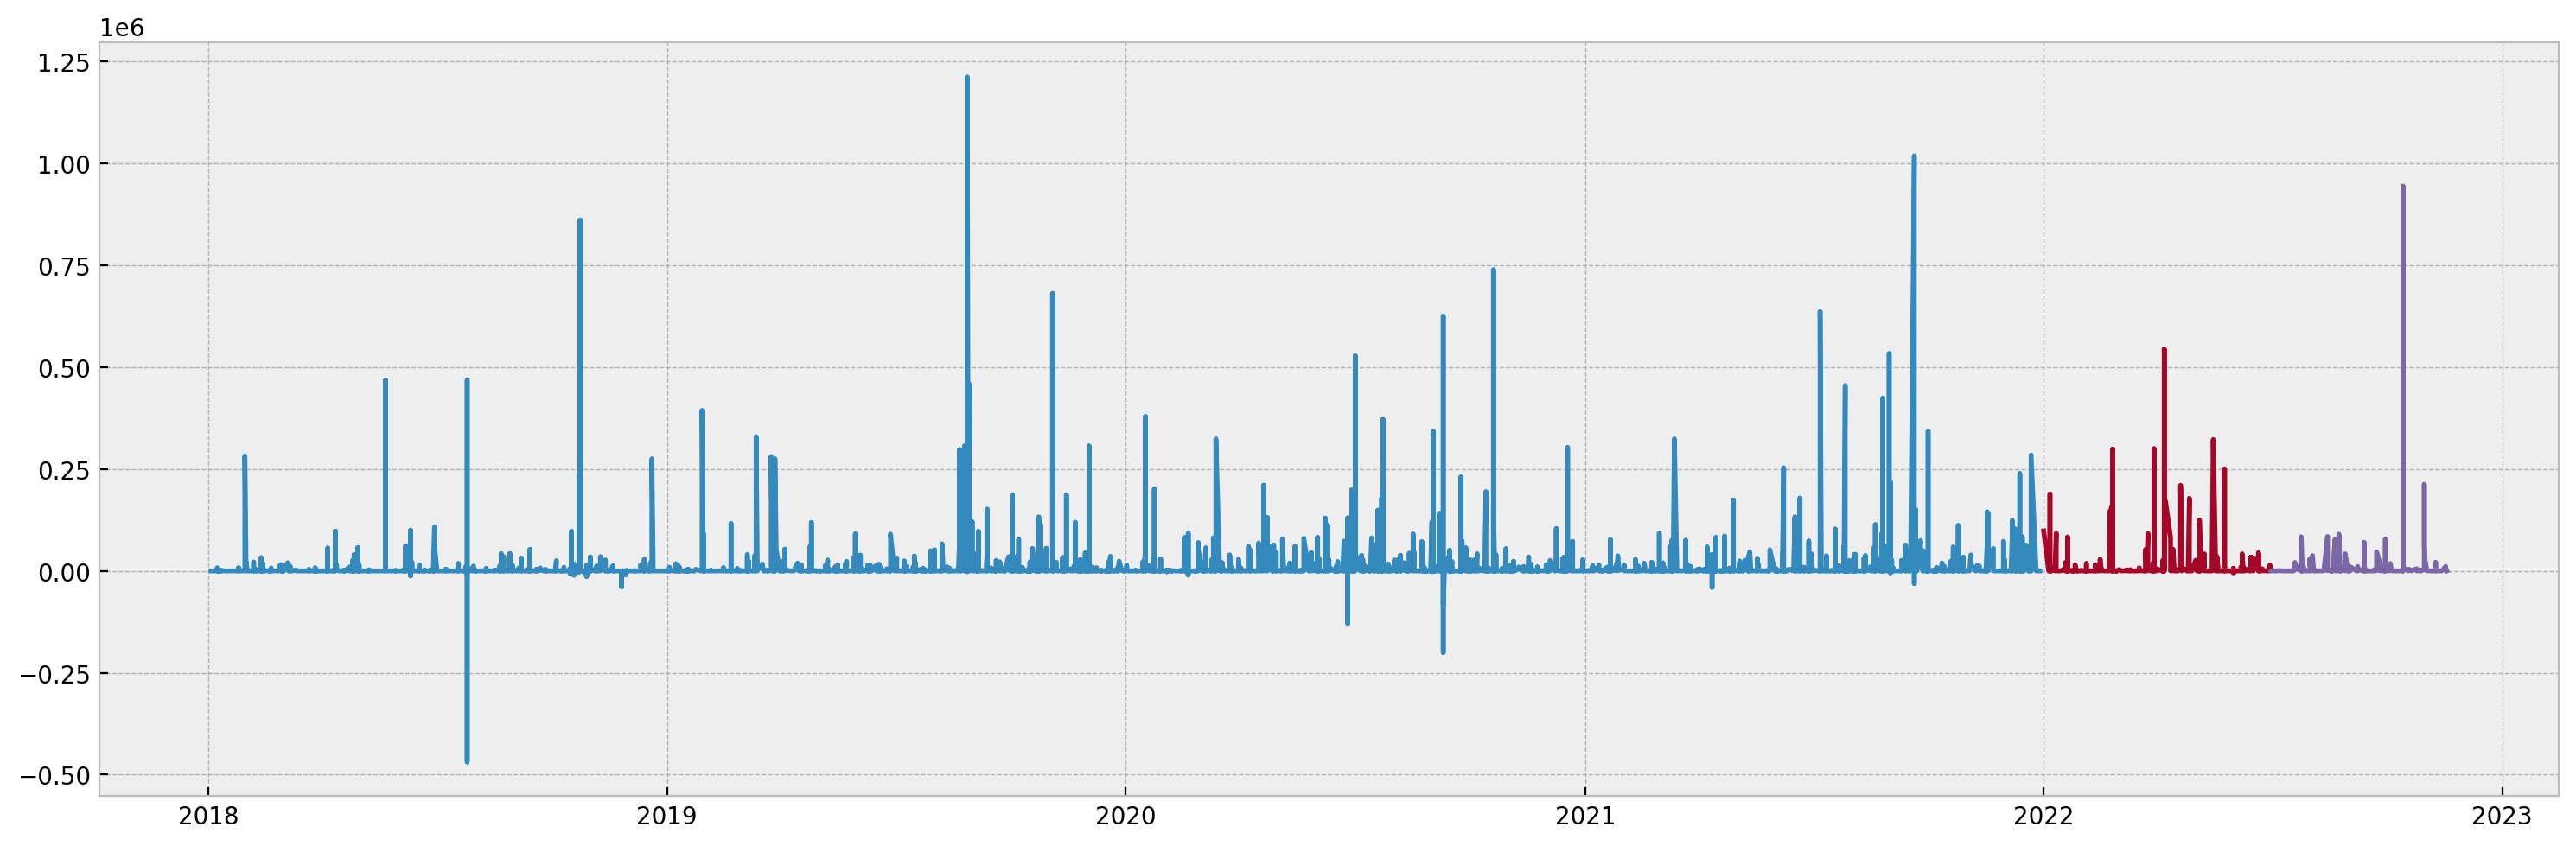

In [54]:
fix, ax = plt.subplots(figsize = (15,5))
plt.plot(sp_train.index, sp_train['purchase_amount'])
plt.plot(sp_validate.index, sp_validate['purchase_amount'])
plt.plot(sp_test.index, sp_test['purchase_amount'])

### In the second group, we see something that appears more patterned. The first group appears very noisy. Breaking our model upon those lines might make cisco purchases more predictable